<h1> <b> <div style='padding:25px;background-color:#9B2335;color:white;border-radius:4px;font-size:100%;text-align: center'>Singapore  Resale Flat Prices Prediction<br> </div></h1>

<h2> <p style="color:Khaki;"> Importing required libraries</p></h2>

In [2]:
import pandas as pd
pd.set_option("display.precision", 4)
pd.set_option('display.float_format', '{:.4f}'.format)


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import pearsonr,kstest, norm, skew,kurtosis, boxcox
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import pickle
from scipy.special import inv_boxcox

sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)
sns.set_style({'axes.facecolor': 'white','axes.edgecolor': 'white'})

color_good = '\033[32m'   # Dark Green for near-zero skew
color_okay = '\033[92m'   # Light Green for slightly positive or slightly negative skew
color_bad = '\033[91m'    # Maroon for significant skew
color_neutral = '\033[0m' # Reset color

from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score
import pickle
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, explained_variance_score,root_mean_squared_error
from sklearn.preprocessing import StandardScaler,LabelEncoder
import time
from colorama import Fore, Style
from xgboost import XGBRegressor, cv, DMatrix


color_positive = Fore.GREEN
reset_color = Style.RESET_ALL


---
title: "Model Building - Before Outlier"
author: "Santhoh Kumar"
date: last-modified
format: 
  html:
    theme: darkly
    fontsize: 1.1em
    max-width: 2800px
    fontcolor: "#ffffff"
    code-fold: true
    code-tools: true
    code-block-bg: true
    code-block-border-left: "#31BAE9"
    toc: true
    toc-depth: 4
    toc-expand: 4
    toc-location: body
    number-sections: true
    number-depth: 3
jupyter: python3
---


## <span style="color:Khaki;">Reading Transformed Dataset

In [3]:
df1=pd.read_feather('data_trans.feather')

In [4]:
df1.sample(4)

,month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,resale_price,floors,floor_no,year,full_address,price_per_sqm,remaining_lease_year,resale_price_boxcox,floor_area_boxcox
109186,1,Bedok,3 Room,65.0000,Improved,1976,132000.0000,3,12,2003,4 Bedok Sth Ave 1 Bedok,2030.7692,72,399.2049,9.2608
186449,3,Jurong East,3 Room,82.0000,New Generation,1982,178000.0000,3,3,1998,232 Jurong East St 21 Jurong East,2170.7317,83,455.4556,10.2476
21636,9,Yishun,3 Room,74.0000,Model A,1987,57000.0000,3,12,1991,266 Yishun St 22 Yishun,770.2703,95,275.5167,9.8017
150050,3,Yishun,5 Room,112.0000,Improved,2018,725000.0000,3,15,2023,502D Yishun St 51 Yishun,6473.2143,94,845.1470,11.7033


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 927465 entries, 0 to 181261
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   month                 927465 non-null  category
 1   town                  927465 non-null  category
 2   flat_type             927465 non-null  category
 3   floor_area_sqm        927465 non-null  float32 
 4   flat_model            927465 non-null  category
 5   lease_commence_date   927465 non-null  category
 6   resale_price          927465 non-null  float64 
 7   floors                927465 non-null  category
 8   floor_no              927465 non-null  int8    
 9   year                  927465 non-null  category
 10  full_address          927465 non-null  category
 11  price_per_sqm         927465 non-null  float64 
 12  remaining_lease_year  927465 non-null  category
 13  resale_price_boxcox   927465 non-null  float64 
 14  floor_area_boxcox     927465 non-null  fl

## <span style="color:Khaki;"> Encoding Categorical Features:</span> 

In [23]:
import pandas as pd
from sklearn.model_selection import KFold

def smooth_target_encoding(df, feature, target, alpha=10, use_median=True):
    if use_median:
        global_central = df[target].median()
        agg = df.groupby(feature, observed=False)[target].agg(['count', 'median'])
        central = agg['median']
    else:
        global_central = df[target].mean()
        agg = df.groupby(feature, observed=False)[target].agg(['count', 'mean'])
        central = agg['mean']
    
    counts = agg['count']
    smooth = (counts * central + alpha * global_central) / (counts + alpha)
    return smooth, global_central

def cross_val_target_encoding(df, features, target, n_splits=5, alpha=10, use_median=True, random_state=42):
    if not all(feature in df.columns for feature in features):
        raise ValueError("One or more features not found in the dataframe")
    if target not in df.columns:
        raise ValueError("Target column not found in the dataframe")
    
    df = df.reset_index(drop=True)  # Ensure unique index labels
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    df_encoded = df.copy()
    
    for train_idx, val_idx in kf.split(df):
        df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]
        for feature in features:
            smooth, global_central = smooth_target_encoding(df_train, feature, target, alpha, use_median)
            df_val.loc[:, feature] = df_val[feature].astype('category')  # Convert to string
            df_encoded.loc[df.index[val_idx], f'{feature}_en_smooth'] = df_val[feature].map(smooth).astype(float).fillna(global_central)
    
    return df_encoded

features = ['town', 'year', 'flat_type', 'flat_model', 'lease_commence_date', 'floors', 'floor_no', 'remaining_lease_year']
df1_encoded = cross_val_target_encoding(df1, features, 'resale_price_boxcox')

# Check the encoded DataFrame
df1_encoded.head()


,month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,resale_price,floors,floor_no,year,...,resale_price_boxcox,floor_area_boxcox,town_en_smooth,year_en_smooth,flat_type_en_smooth,flat_model_en_smooth,lease_commence_date_en_smooth,floors_en_smooth,floor_no_en_smooth,remaining_lease_year_en_smooth
0,1,Ang Mo Kio,1 Room,31.0000,Improved,1977,9000.0000,3,12,1990,...,121.3652,6.6029,505.0113,265.9802,258.3615,589.7300,485.7942,568.9832,565.5734,533.6327
1,1,Ang Mo Kio,1 Room,31.0000,Improved,1977,6000.0000,3,6,1990,...,101.2247,6.6029,505.0115,265.9832,258.2964,589.7301,485.7950,568.9832,556.0581,533.6331
2,1,Ang Mo Kio,1 Room,31.0000,Improved,1977,8000.0000,3,12,1990,...,115.1411,6.6029,505.0113,265.9784,258.3529,590.4499,484.7541,568.9832,565.5734,535.4714
3,1,Ang Mo Kio,1 Room,31.0000,Improved,1977,6000.0000,3,9,1990,...,101.2247,6.6029,505.0114,265.9823,256.0291,589.7300,484.7544,568.9832,560.4088,534.5532
4,1,Ang Mo Kio,3 Room,73.0000,New Generation,1976,47200.0000,3,6,1990,...,253.4578,9.7438,505.0115,265.9832,449.7767,482.6191,497.5522,568.9832,556.0581,520.5298


In [8]:
df1.columns

Index(['month', 'town', 'flat_type', 'floor_area_sqm', 'flat_model',
       'lease_commence_date', 'resale_price', 'floors', 'floor_no', 'year',
       'full_address', 'price_per_sqm', 'remaining_lease_year',
       'resale_price_boxcox', 'floor_area_boxcox'],
      dtype='object')

In [5]:
town_en = df1.groupby('town',observed=False)['resale_price_boxcox'].median().rank(method='first').reset_index().sort_values('resale_price_boxcox')
town_en_list = dict(zip(town_en['town'], town_en['resale_price_boxcox'].astype(int)))
print(town_en_list)

{'Lim Chu Kang': 1, 'Queenstown': 2, 'Ang Mo Kio': 3, 'Clementi': 4, 'Geylang': 5, 'Bedok': 6, 'Bukit Batok': 7, 'Yishun': 8, 'Toa Payoh': 9, 'Jurong East': 10, 'Central Area': 11, 'Jurong West': 12, 'Kallang/Whampoa': 13, 'Woodlands': 14, 'Hougang': 15, 'Serangoon': 16, 'Marine Parade': 17, 'Bukit Merah': 18, 'Bukit Panjang': 19, 'Tampines': 20, 'Choa Chu Kang': 21, 'Sembawang': 22, 'Pasir Ris': 23, 'Bishan': 24, 'Bukit Timah': 25, 'Sengkang': 26, 'Punggol': 27}


In [6]:
df1['town_en'] = df1['town'].map(town_en_list)
df1['town_en'] = df1['town_en'].astype('int8')

In [7]:
year_en = df1.groupby('year',observed=False)['resale_price_boxcox'].median().rank(method='first').reset_index().sort_values('resale_price_boxcox')
year_en_list = dict(zip(year_en['year'], year_en['resale_price_boxcox'].astype(int)))
print(year_en_list)

{1990: 1, 1991: 2, 1992: 3, 1993: 4, 1994: 5, 1995: 6, 2002: 7, 2003: 8, 2004: 9, 2001: 10, 2005: 11, 2006: 12, 1999: 13, 2000: 14, 1998: 15, 1996: 16, 2007: 17, 1997: 18, 2008: 19, 2009: 20, 2010: 21, 2019: 22, 2015: 23, 2018: 24, 2011: 25, 2016: 26, 2017: 27, 2014: 28, 2020: 29, 2012: 30, 2013: 31, 2021: 32, 2022: 33, 2023: 34, 2024: 35}


In [8]:
df1['year_en'] = df1['year'].map(year_en_list)
df1['year_en'] = df1['year_en'].astype('int8')

In [9]:
flat_type_en = df1.groupby('flat_type',observed=False)['resale_price_boxcox'].median().rank(method='first').reset_index().sort_values('resale_price_boxcox')
flat_type_en_list = dict(zip(flat_type_en['flat_type'], flat_type_en['resale_price_boxcox'].astype(int)))
print(flat_type_en_list)

{'1 Room': 1, '2 Room': 2, '3 Room': 3, '4 Room': 4, '5 Room': 5, 'Executive': 6, 'Multi Generation': 7}


In [10]:
df1['flat_type_en'] = df1['flat_type'].map(flat_type_en_list)
df1['flat_type_en'] = df1['flat_type_en'].astype('int8')

In [11]:
flat_model_en = df1.groupby('flat_model',observed=False)['resale_price_boxcox'].median().rank(method='first').reset_index().sort_values('resale_price_boxcox')
flat_model_en_list = dict(zip(flat_model_en['flat_model'], flat_model_en['resale_price_boxcox'].astype(int)))
print(flat_model_en_list)

{'New Generation': 1, 'Standard': 2, 'Simplified': 3, 'Model A2': 4, '2-Room': 5, 'Model A': 6, 'Improved': 7, 'Improved-Maisonette': 8, 'Model A-Maisonette': 9, 'Premium Apartment': 10, 'Adjoined Flat': 11, 'Maisonette': 12, 'Apartment': 13, 'Terrace': 14, 'Multi Generation': 15, 'Premium Maisonette': 16, '3Gen': 17, 'Dbss': 18, 'Premium Apartment Loft': 19, 'Type S1': 20, 'Type S2': 21}


In [12]:
df1['flat_model_en'] = df1['flat_model'].map(flat_model_en_list)
df1['flat_model_en'] = df1['flat_model_en'].astype('int8')

In [13]:
lease_commence_en = df1.groupby('lease_commence_date',observed=False)['resale_price_boxcox'].median().rank(method='first').reset_index().sort_values('resale_price_boxcox')
lease_commence_en_list = dict(zip(lease_commence_en['lease_commence_date'], lease_commence_en['resale_price_boxcox'].astype(int)))
print(lease_commence_en_list)

{1969: 1, 1971: 2, 1967: 3, 1968: 4, 1973: 5, 1970: 6, 1972: 7, 1974: 8, 1977: 9, 1980: 10, 1983: 11, 1975: 12, 1981: 13, 1976: 14, 1978: 15, 1979: 16, 1966: 17, 1982: 18, 1985: 19, 1984: 20, 1986: 21, 1987: 22, 1988: 23, 1990: 24, 1989: 25, 1991: 26, 1997: 27, 1998: 28, 1996: 29, 1999: 30, 1994: 31, 1993: 32, 2000: 33, 1995: 34, 1992: 35, 2001: 36, 2002: 37, 2003: 38, 2004: 39, 2012: 40, 2014: 41, 2015: 42, 2005: 43, 2007: 44, 2010: 45, 2013: 46, 2008: 47, 2016: 48, 2009: 49, 2017: 50, 2018: 51, 2019: 52, 2006: 53, 2020: 54, 2011: 55}


In [14]:
df1['lease_commence_en'] = df1['lease_commence_date'].map(lease_commence_en_list)
df1['lease_commence_en'] = df1['lease_commence_en'].astype('int8')

In [15]:
floors_en = df1.groupby('floors',observed=False)['resale_price_boxcox'].median().rank(method='first').reset_index().sort_values('resale_price_boxcox')
floors_en_list = dict(zip(floors_en['floors'], floors_en['resale_price_boxcox'].astype(int)))
print(floors_en_list)

{3: 1, 5: 2}


In [16]:
df1['floors_en'] = df1['floors'].map(floors_en_list)
df1['floors_en'] = df1['floors_en'].astype('int8')

In [17]:
floor_no_en = df1.groupby('floor_no',observed=False)['resale_price_boxcox'].median().rank(method='first').reset_index().sort_values('resale_price_boxcox')
floor_no_en_list = dict(zip(floor_no_en['floor_no'], floor_no_en['resale_price_boxcox'].astype(int)))
print(floor_no_en_list)

{3: 1, 6: 2, 9: 3, 12: 4, 15: 5, 5: 6, 18: 7, 10: 8, 21: 9, 24: 10, 20: 11, 27: 12, 25: 13, 35: 14, 40: 15, 30: 16, 33: 17, 36: 18, 39: 19, 42: 20, 45: 21, 48: 22, 51: 23}


In [18]:
df1['floor_no_en'] = df1['floor_no'].map(floor_no_en_list)
df1['floor_no_en'] = df1['floor_no_en'].astype('int8')

In [19]:
remaining_lease_year_en = df1.groupby('remaining_lease_year',observed=False)['resale_price_boxcox'].median().rank(method='first').reset_index().sort_values('resale_price_boxcox')
remaining_lease_year_en_list = dict(zip(remaining_lease_year_en['remaining_lease_year'], remaining_lease_year_en['resale_price_boxcox'].astype(int)))
print(remaining_lease_year_en_list)

{81: 1, 82: 2, 83: 3, 80: 4, 79: 5, 84: 6, 78: 7, 85: 8, 77: 9, 76: 10, 86: 11, 75: 12, 87: 13, 88: 14, 48: 15, 74: 16, 89: 17, 49: 18, 90: 19, 47: 20, 72: 21, 73: 22, 71: 23, 45: 24, 46: 25, 70: 26, 91: 27, 44: 28, 43: 29, 50: 30, 69: 31, 92: 32, 93: 33, 68: 34, 41: 35, 42: 36, 51: 37, 67: 38, 96: 39, 52: 40, 58: 41, 66: 42, 94: 43, 59: 44, 95: 45, 57: 46, 100: 47, 65: 48, 101: 49, 53: 50, 56: 51, 64: 52, 54: 53, 55: 54, 98: 55, 60: 56, 63: 57, 62: 58, 61: 59, 97: 60, 99: 61}


In [20]:
df1['remaining_lease_year_en'] = df1['remaining_lease_year'].map(remaining_lease_year_en_list)
df1['remaining_lease_year_en'] = df1['remaining_lease_year_en'].astype('int8')

In [21]:
df1.columns

Index(['month', 'town', 'flat_type', 'floor_area_sqm', 'flat_model',
       'lease_commence_date', 'resale_price', 'floors', 'floor_no', 'year',
       'full_address', 'price_per_sqm', 'remaining_lease_year',
       'resale_price_boxcox', 'floor_area_boxcox', 'town_en', 'year_en',
       'flat_type_en', 'flat_model_en', 'lease_commence_en', 'floors_en',
       'floor_no_en', 'remaining_lease_year_en'],
      dtype='object')

In [25]:
df1_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 927465 entries, 0 to 927464
Data columns (total 23 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   month                           927465 non-null  category
 1   town                            927465 non-null  category
 2   flat_type                       927465 non-null  category
 3   floor_area_sqm                  927465 non-null  float32 
 4   flat_model                      927465 non-null  category
 5   lease_commence_date             927465 non-null  category
 6   resale_price                    927465 non-null  float64 
 7   floors                          927465 non-null  category
 8   floor_no                        927465 non-null  int8    
 9   year                            927465 non-null  category
 10  full_address                    927465 non-null  category
 11  price_per_sqm                   927465 non-null  float64 
 12  re

In [26]:
df1_encoded.sample(3)

,month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,resale_price,floors,floor_no,year,...,resale_price_boxcox,floor_area_boxcox,town_en_smooth,year_en_smooth,flat_type_en_smooth,flat_model_en_smooth,lease_commence_date_en_smooth,floors_en_smooth,floor_no_en_smooth,remaining_lease_year_en_smooth
97769,8,Bedok,Executive,148.0000,Maisonette,1985,425000.0000,3,3,1995,...,668.1877,13.1440,524.3077,466.6084,710.0644,705.5331,521.4684,568.9832,551.6639,559.5455
8606,8,Toa Payoh,3 Room,78.0000,Improved,1972,40000.0000,3,24,1990,...,235.5522,10.0284,533.6339,265.9784,449.7767,590.4499,463.4947,568.9832,701.4831,508.2480
680181,3,Queenstown,3 Room,56.0000,Standard,1970,320000.0000,3,3,2013,...,589.7310,8.6686,481.7079,688.4551,449.7767,481.5903,452.1860,568.9832,551.6639,620.9643


## <p Style="color:Khaki;"> Feature Selection:

### <p Style="color:Aqua;"> Dropping Categorical Features & Unnecessary:

In [27]:
df2 = df1_encoded.drop(columns=['month', 'town', 'flat_type', 'floor_area_sqm', 'flat_model',
       'lease_commence_date', 'resale_price', 'floors', 'floor_no', 'year',
       'full_address', 'price_per_sqm', 'remaining_lease_year',],axis=1).copy()

In [28]:
df2.columns

Index(['resale_price_boxcox', 'floor_area_boxcox', 'town_en_smooth',
       'year_en_smooth', 'flat_type_en_smooth', 'flat_model_en_smooth',
       'lease_commence_date_en_smooth', 'floors_en_smooth',
       'floor_no_en_smooth', 'remaining_lease_year_en_smooth'],
      dtype='object')

### <p Style="color:Aqua;"> Correlation:

In [30]:
df2['location_specifics'] = df2['floor_area_boxcox'] *df2['town_en_smooth']
df2['floor_area_year'] = df2['floor_area_boxcox'] / df2['remaining_lease_year_en_smooth']
df2['age']=df2['year_en_smooth'] - df2['lease_commence_date_en_smooth']
df2['flat_area'] = df2['flat_type_en_smooth'] * df2['floor_area_boxcox']
df2['model_area'] = df2['flat_model_en_smooth'] * df2['floor_area_boxcox']
df2['floors_area'] = df2['floors_en_smooth'] * df2['floor_area_year']
df2['town_mean_price'] = df2.groupby('town_en_smooth')['floor_area_boxcox'].transform('median')
df2['flat_type_mean_price'] = df2.groupby('flat_type_en_smooth')['floor_area_boxcox'].transform('median')
df2['floor_area_bin'] = pd.cut(df2['floor_area_boxcox'], bins=5, labels=False)
df2['floor_area_year'] = df2['floor_area_boxcox'] / (2024 - df2['remaining_lease_year_en_smooth'].astype(int))
df2['floor_weightage'] = (df2['floor_no_en_smooth'] -  df2['floors_en_smooth'] ) * df2['floor_area_boxcox']


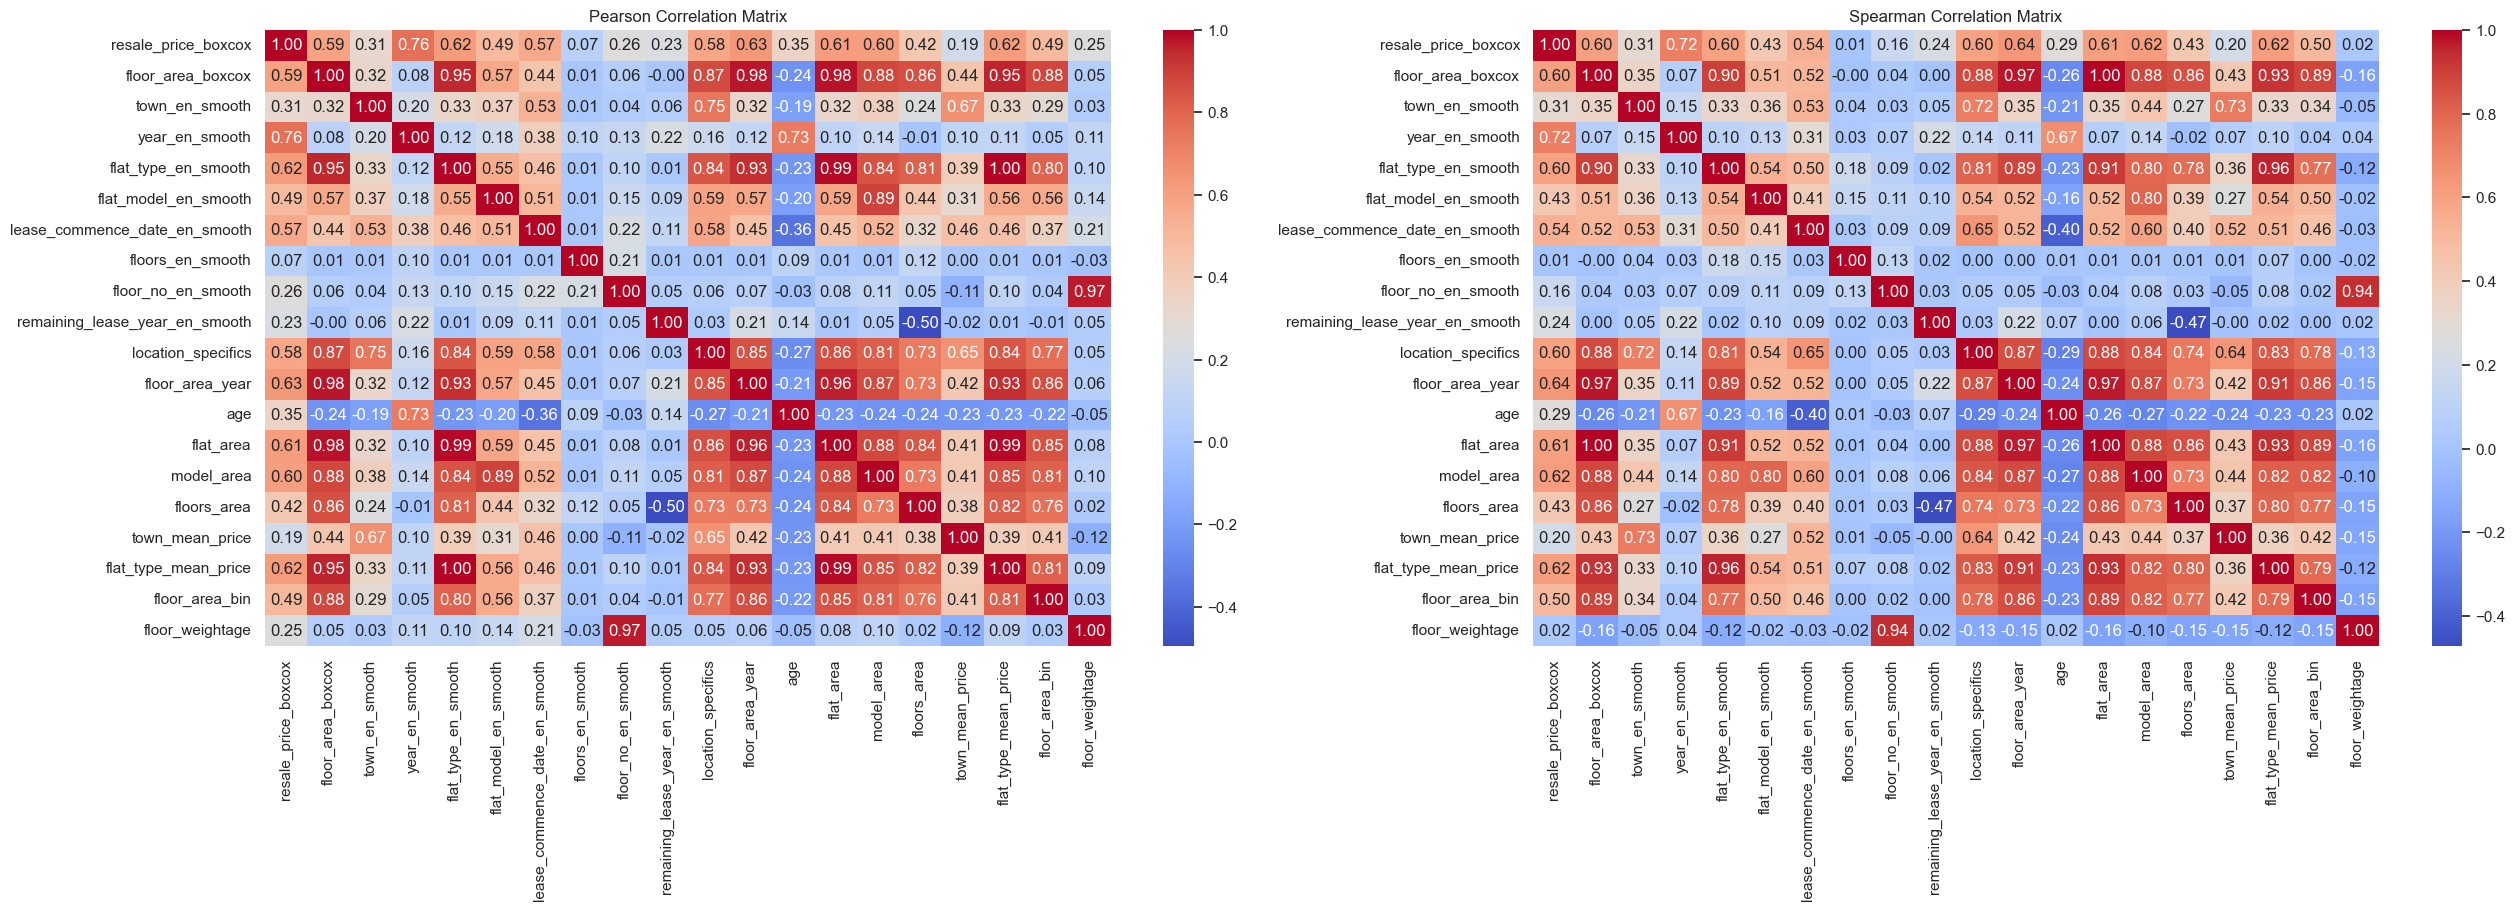

In [31]:
cor_col = df2.select_dtypes(include='number')
correlation_matrix_pear = cor_col.corr()
plt.figure(figsize=(30,8))
plt.subplot(1,2,1)
sns.heatmap(correlation_matrix_pear,annot=True,fmt='.2f',cmap='coolwarm')
plt.title('Pearson Correlation Matrix')


cor_col = df2.select_dtypes(include='number')
correlation_matrix = cor_col.corr(method='spearman')
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix,annot=True,fmt='.2f',cmap='coolwarm')
plt.title('Spearman Correlation Matrix')
plt.show()

In [32]:
target_corr = df2.select_dtypes(include='number').corr(method='spearman')['resale_price_boxcox'].abs().sort_values(ascending=False)[1:]
target_corr

year_en_smooth                   0.7221
floor_area_year                  0.6409
flat_type_mean_price             0.6163
model_area                       0.6156
flat_area                        0.6062
floor_area_boxcox                0.6048
location_specifics               0.6010
flat_type_en_smooth              0.5992
lease_commence_date_en_smooth    0.5440
floor_area_bin                   0.5042
flat_model_en_smooth             0.4336
floors_area                      0.4273
town_en_smooth                   0.3112
age                              0.2862
remaining_lease_year_en_smooth   0.2379
town_mean_price                  0.2032
floor_no_en_smooth               0.1579
floor_weightage                  0.0242
floors_en_smooth                 0.0100
Name: resale_price_boxcox, dtype: float64

## <span style="color:Khaki;"> Splitting train and test Data:</span> 

In [33]:
df2.columns

Index(['resale_price_boxcox', 'floor_area_boxcox', 'town_en_smooth',
       'year_en_smooth', 'flat_type_en_smooth', 'flat_model_en_smooth',
       'lease_commence_date_en_smooth', 'floors_en_smooth',
       'floor_no_en_smooth', 'remaining_lease_year_en_smooth',
       'location_specifics', 'floor_area_year', 'age', 'flat_area',
       'model_area', 'floors_area', 'town_mean_price', 'flat_type_mean_price',
       'floor_area_bin', 'floor_weightage'],
      dtype='object')

In [34]:
x_train, x_test, y_train, y_test = train_test_split(df2.drop(['resale_price_boxcox'], axis=1), df2[['resale_price_boxcox']].values.ravel(), test_size=0.2, random_state=42)

## <span style="color:Khaki;"> Scaling Data:</span> 

In [35]:
scale_reg = StandardScaler().fit(x_train)
x_train=scale_reg.transform(x_train)
x_test=scale_reg.transform(x_test)

In [36]:
x_train

array([[ 0.54375758,  0.81501501, -0.51982042, ...,  0.12683854,
         0.83132755, -0.39979473],
       [ 1.15207595,  0.12209173,  0.88017301, ...,  1.03922316,
         0.83132755, -0.1433283 ],
       [-0.09522247, -1.23936054,  0.88017301, ...,  0.12683854,
        -0.85557253, -0.48757438],
       ...,
       [-0.42320007, -0.83929444, -0.30945044, ..., -1.15354507,
        -0.85557253, -0.36189021],
       [-0.13516168,  2.28538773,  1.1166667 , ...,  0.08725905,
        -0.85557253, -0.48547599],
       [-1.14708609,  0.13961131, -0.30945044, ..., -1.15354507,
        -0.85557253, -0.33351441]])

### <p Style="color:Aqua;"> Pickle Scaling:

with open(r'pkls/scale_reg.pkl', 'wb') as f:
    pickle.dump(scale_reg,f)

In [37]:
print(x_train.shape, '\n\n',y_train.shape)
print(x_test.shape, '\n\n',y_test.shape)

(741972, 19) 

 (741972,)
(185493, 19) 

 (185493,)


## <span style="color:Khaki;"> Training Models:</span> 

### <p Style="color:Aqua;"> Linear Regression:

In [38]:
start_time = time.time()


LR_model = LinearRegression()

LR_model.fit(x_train,y_train)

y_preds=LR_model.predict(x_test)
y_preds_train = LR_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Coefficients - {reset_color} {LR_model.coef_} ")


print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)


Training Time: 1.57 seconds

Coefficients -  [ 75.69618261  31.48190431  59.5010666  -52.87755336  -2.99822726
  36.73093476   3.05382426   2.02319456  -7.78046454 -39.0782662
  20.52871211  32.75618354  36.07373345  10.77585049 -23.56108947
 -28.75255714  44.46448706  -5.74814418  10.74675996] 
Test Mean Squared Error  -- 1669.16
Train Mean Squared Error  -- 1647.63

Test Root Mean Squared Error  -- 40.86
Train Root Mean Squared Error  -- 40.59

Test R2 Score  -- 0.92
Train R2 Score  -- 0.92

Test Mean Absolute Error  -- 31.73
Train Mean Absolute Error  -- 31.53

Test Median Absolute Error  -- 26.15
Train Median Absolute Error  -- 25.91

Test Explained Var  -- 0.92
Train Explained Var  -- 0.92

--------------------------------------------------


### <p Style="color:Aqua;"> Lasso:

In [39]:
start_time = time.time()


Lasso_model = Lasso(random_state=42)

Lasso_model.fit(x_train,y_train)

y_preds=Lasso_model.predict(x_test)
y_preds_train = Lasso_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

Training Time: 33.15 seconds

Test Mean Squared Error  -- 1699.39
Train Mean Squared Error  -- 1677.43

Test Root Mean Squared Error  -- 41.22
Train Root Mean Squared Error  -- 40.96

Test R2 Score  -- 0.91
Train R2 Score  -- 0.91

Test Mean Absolute Error  -- 31.93
Train Mean Absolute Error  -- 31.70

Test Median Absolute Error  -- 26.21
Train Median Absolute Error  -- 25.93

Test Explained Var  -- 0.91
Train Explained Var  -- 0.91

--------------------------------------------------


### <p Style="color:Aqua;"> ElasticNet:

In [40]:
start_time = time.time()


EN_model = ElasticNet(random_state=42)

EN_model.fit(x_train,y_train)

y_preds=EN_model.predict(x_test)
y_preds_train = EN_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

Training Time: 5.21 seconds

Test Mean Squared Error  -- 2422.64
Train Mean Squared Error  -- 2393.11

Test Root Mean Squared Error  -- 49.22
Train Root Mean Squared Error  -- 48.92

Test R2 Score  -- 0.88
Train R2 Score  -- 0.88

Test Mean Absolute Error  -- 37.22
Train Mean Absolute Error  -- 37.00

Test Median Absolute Error  -- 29.69
Train Median Absolute Error  -- 29.58

Test Explained Var  -- 0.88
Train Explained Var  -- 0.88

--------------------------------------------------


### <p Style="color:Aqua;"> Decision Tree Regressor:

In [41]:
start_time = time.time()

DT_model = DecisionTreeRegressor(random_state=42,max_depth=7)

DT_model.fit(x_train,y_train)

y_preds=DT_model.predict(x_test)
y_preds_train = DT_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

Training Time: 6.05 seconds

Test Mean Squared Error  -- 1662.67
Train Mean Squared Error  -- 1654.03

Test Root Mean Squared Error  -- 40.78
Train Root Mean Squared Error  -- 40.67

Test R2 Score  -- 0.92
Train R2 Score  -- 0.92

Test Mean Absolute Error  -- 31.00
Train Mean Absolute Error  -- 30.94

Test Median Absolute Error  -- 24.51
Train Median Absolute Error  -- 24.48

Test Explained Var  -- 0.92
Train Explained Var  -- 0.92

--------------------------------------------------


### <p Style="color:Aqua;"> KNN Regressor:

In [40]:
start_time = time.time()
params = {'n_neighbors' : [2,3,4,5]}

KNN_grid_model = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=params, cv=5, scoring='neg_mean_squared_error',verbose=3, n_jobs=1,error_score='raise')

KNN_grid_model.fit(x_train,y_train)

y_preds=KNN_grid_model.predict(x_test)
y_preds_train = KNN_grid_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ..................n_neighbors=2;, score=-834.812 total time=  14.1s
[CV 2/5] END ..................n_neighbors=2;, score=-832.900 total time=  13.6s
[CV 3/5] END ..................n_neighbors=2;, score=-834.816 total time=  13.3s
[CV 4/5] END ..................n_neighbors=2;, score=-836.713 total time=  13.1s
[CV 5/5] END ..................n_neighbors=2;, score=-824.994 total time=  12.3s
[CV 1/5] END ..................n_neighbors=3;, score=-804.232 total time=  13.7s
[CV 2/5] END ..................n_neighbors=3;, score=-805.496 total time=  12.8s
[CV 3/5] END ..................n_neighbors=3;, score=-804.944 total time=  13.2s
[CV 4/5] END ..................n_neighbors=3;, score=-806.190 total time=  13.3s
[CV 5/5] END ..................n_neighbors=3;, score=-789.945 total time=  13.5s
[CV 1/5] END ..................n_neighbors=4;, score=-802.000 total time=  16.8s
[CV 2/5] END ..................n_neighbors=4;, sc

In [41]:
print(f"KNN Best Score - {KNN_grid_model.best_score_}\n\nKNN Best Params - {KNN_grid_model.best_params_}\n\nKNN Best Estimater - {KNN_grid_model.best_estimator_} \n\nKNN Best Index - {KNN_grid_model.best_index_} ")

KNN Best Score - -801.1236158353414

KNN Best Params - {'n_neighbors': 4}

KNN Best Estimater - KNeighborsRegressor(n_neighbors=4) 

KNN Best Index - 2 


In [42]:
KNN_model = KNeighborsRegressor(n_neighbors=4)

KNN_model.fit(x_train,y_train)

y_preds=KNN_model.predict(x_test)
y_preds_train = KNN_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

KeyboardInterrupt: 

### <p Style="color:Aqua;"> Extra Tree Regressor:

In [ ]:
start_time = time.time()

ET_model = ExtraTreesRegressor(random_state=42)

ET_model.fit(x_train,y_train)

y_preds=ET_model.predict(x_test)
y_preds_train = ET_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

### <p Style="color:Aqua;"> Random Forest Regressor:

In [ ]:
start_time = time.time()

RF_model = RandomForestRegressor(random_state=42,)

RF_model.fit(x_train,y_train)

y_preds=RF_model.predict(x_test)
y_preds_train = RF_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

### <p Style="color:Aqua;"> XG Boost Regressor:

In [43]:
start_time = time.time()

XGB_model = XGBRegressor(random_state=42)

XGB_model.fit(x_train,y_train)

y_preds=XGB_model.predict(x_test)
y_preds_train = XGB_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

Training Time: 5.69 seconds

Test Mean Squared Error  -- 841.98
Train Mean Squared Error  -- 486.00

Test Root Mean Squared Error  -- 29.02
Train Root Mean Squared Error  -- 22.05

Test R2 Score  -- 0.96
Train R2 Score  -- 0.98

Test Mean Absolute Error  -- 21.74
Train Mean Absolute Error  -- 16.66

Test Median Absolute Error  -- 16.65
Train Median Absolute Error  -- 13.01

Test Explained Var  -- 0.96
Train Explained Var  -- 0.98

--------------------------------------------------


In [44]:
cols = list(df2.columns)
cols = [col for col in cols if col not in ['resale_price_boxcox']]
print(cols)

['floor_area_boxcox', 'town_en_smooth', 'year_en_smooth', 'flat_type_en_smooth', 'flat_model_en_smooth', 'lease_commence_date_en_smooth', 'floors_en_smooth', 'floor_no_en_smooth', 'remaining_lease_year_en_smooth', 'location_specifics', 'floor_area_year', 'age', 'flat_area', 'model_area', 'floors_area', 'town_mean_price', 'flat_type_mean_price', 'floor_area_bin', 'floor_weightage']


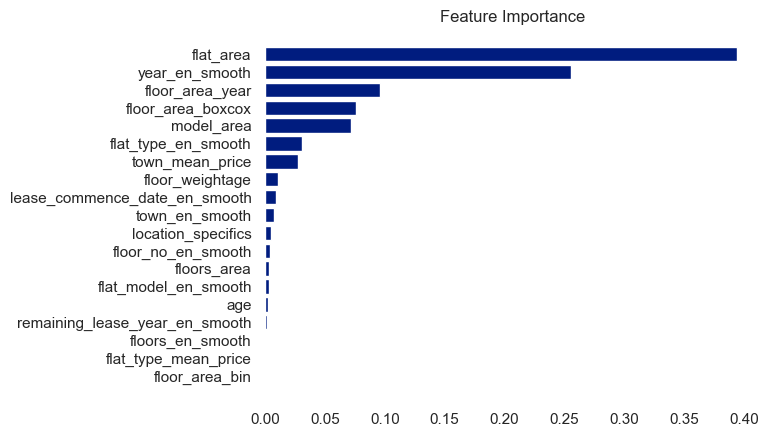

In [45]:
# Assuming XGB_model is your trained model
feature_importance = XGB_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

# Use a list comprehension to get the sorted column names
sorted_cols = [cols[i] for i in sorted_idx]
plt.barh(pos, feature_importance[sorted_idx])
plt.yticks(pos, sorted_cols)
plt.title('Feature Importance')
plt.show()

## <span style="color:Khaki;"> Model Selection:</span> 

### <p style="color:Aqua"> Evaluation: </p>

- <span Style="color:Aqua"> <b>Linear Regression and Lasso - </b></span> Both have the same R2 score and similar MSEs. They show a good fit but are slightly worse compared to other models like XGBoost and Extra Trees.

 - <span Style="color:Aqua"> <b> ElasticNet - </b></span> Shows lower performance with an R2 score of 0.81, indicating underfitting.

 - <span Style="color:Aqua"> <b> Decision Tree Regressor - </b></span>  Shows good performance with an R2 score of 0.90 but is outperformed by ensemble methods.

 - <span Style="color:Aqua"> <b> KNeighbors Regressor - </b></span> Shows very high R2 scores (0.96 for test, 0.98 for train) but has a significant difference between training and testing MSEs, indicating potential overfitting.

 - <span Style="color:Aqua"> <b> Extra Trees Regressor - </b></span> Shows excellent performance with very high R2 scores but has a significant difference between training and testing MSEs, indicating potential overfitting.

 - <span Style="color:Aqua"> <b> XGBoost Regressor - </b></span> Shows excellent performance with very high R2 scores for both test and train. It has a smaller gap between training and testing errors compared to Extra Trees, indicating less overfitting.

#### <p Style="color:Aqua"> XGBoost Regressor is the best model in this case, with balanced performance and minimal overfitting.</p> <p Style="color:Aqua"> Random Forest & Etra Tree Regressors are also shows excellent performanance and also shows <strong> severe overfitting. </strong>

##### <p Style="color:Tomato"> I Choose XGB Regressor and also try to tune Random Forest and Extra Tree Model to reduce overfitting. </p>

## <span style="color:Khaki;"> Hyperparameter Tuning with Grid Search for XGB :</span> 

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.3, 0.4, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
}

In [ ]:
xgb_grid = GridSearchCV(estimator=XGBRegressor(random_state=42), param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=3, n_jobs=1,error_score='raise')
xgb_grid.fit(x_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV 1/3] END learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.6;, score=-807.553 total time=   1.9s
[CV 2/3] END learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.6;, score=-810.867 total time=   1.6s
[CV 3/3] END learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.6;, score=-793.478 total time=   1.7s
[CV 1/3] END learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.8;, score=-802.778 total time=   1.7s
[CV 2/3] END learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.8;, score=-800.476 total time=   1.8s
[CV 3/3] END learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.8;, score=-787.094 total time=   1.3s
[CV 1/3] END learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0;, score=-805.754 total time=   1.5s
[CV 2/3] END learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0;, score=-809.884 total time=   1.4s
[CV 3/3] END learning_rate=0.3, ma

GridSearchCV(cv=3, error_score='raise',
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=1,
             param_grid={'learning_rate': [0.3, 0.4, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=3)

In [ ]:
print(f"XGB Best Score - {xgb_grid.best_score_}\n\nXGB Best Params - {xgb_grid.best_params_}\n\nXGB Best Estimater - {xgb_grid.best_estimator_} \n\nXGB Best Index - {xgb_grid.best_index_} ")

XGB Best Score - -421.54153275150355

XGB Best Params - {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}

XGB Best Estimater - XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...) 

XGB Best Index - 26 


In [46]:
start_time = time.time()

XGB_model = XGBRegressor(learning_rate=.25, max_depth=8, n_jobs=-1, subsample = 1.0,n_estimators=600, random_state=42) 

XGB_model.fit(x_train,y_train)

y_preds=XGB_model.predict(x_test)
y_preds_train = XGB_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

Training Time: 33.20 seconds

Test Mean Squared Error  -- 852.19
Train Mean Squared Error  -- 296.73

Test Root Mean Squared Error  -- 29.19
Train Root Mean Squared Error  -- 17.23

Test R2 Score  -- 0.96
Train R2 Score  -- 0.98

Test Mean Absolute Error  -- 21.42
Train Mean Absolute Error  -- 12.90

Test Median Absolute Error  -- 15.83
Train Median Absolute Error  -- 9.92

Test Explained Var  -- 0.96
Train Explained Var  -- 0.98

--------------------------------------------------


387
312
XGB_model = XGBRegressor(learning_rate=.25, max_depth=8, n_jobs=-1, subsample = 1.0,n_estimators=600, random_state=42) 
['resale_price_boxcox','age_year','floors_en','floors_area', 'town_mean_price', 'flat_type_mean_price',
       'floor_area_bin']


#### <span style="color:Aqua;"> We see a noticable changes in the error after tuning.</span> 

#### <span style="color:Aqua;"> I tuned few parameters manually so doing cross validations:</span> 

In [50]:
kf=KFold(n_splits=10,shuffle=True,random_state=42)
xgb_cv_score = cross_val_score(XGB_model,x_train,y_train, cv=kf)
print(f'Cross validations scores \n\n {xgb_cv_score}\n\n')
print(f'Cross validations scores mean \n\n {np.mean(xgb_cv_score)}')

Cross validations scores 

 [0.97972729 0.97995981 0.98024304 0.98008964 0.97954628 0.97943451
 0.97986312 0.98038776 0.98005251 0.9801103 ]


Cross validations scores mean 

 0.9799414262695159


#### <span style="color:Aqua;"> Pickling the Model:</span> 

In [80]:
import os
os.makedirs('pkls', exist_ok=True)
with open(r'pkls/XGB_model.pkl', 'wb') as f:
    pickle.dump(XGB_model,f)

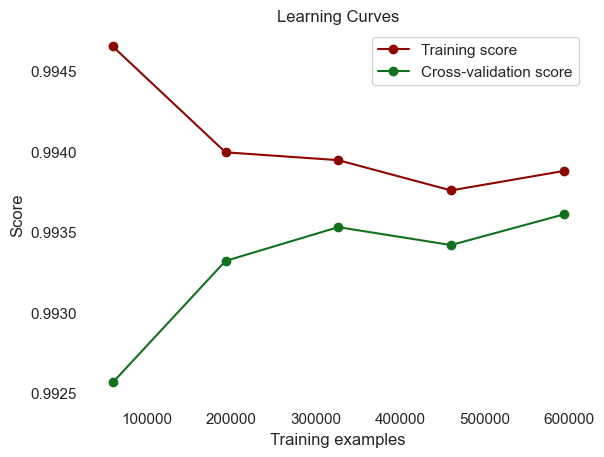

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, valid_scores = learning_curve(XGB_model, x_train, y_train, cv=5)

plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', color="r", label="Training score")
plt.plot(train_sizes, valid_scores.mean(axis=1), 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curves")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

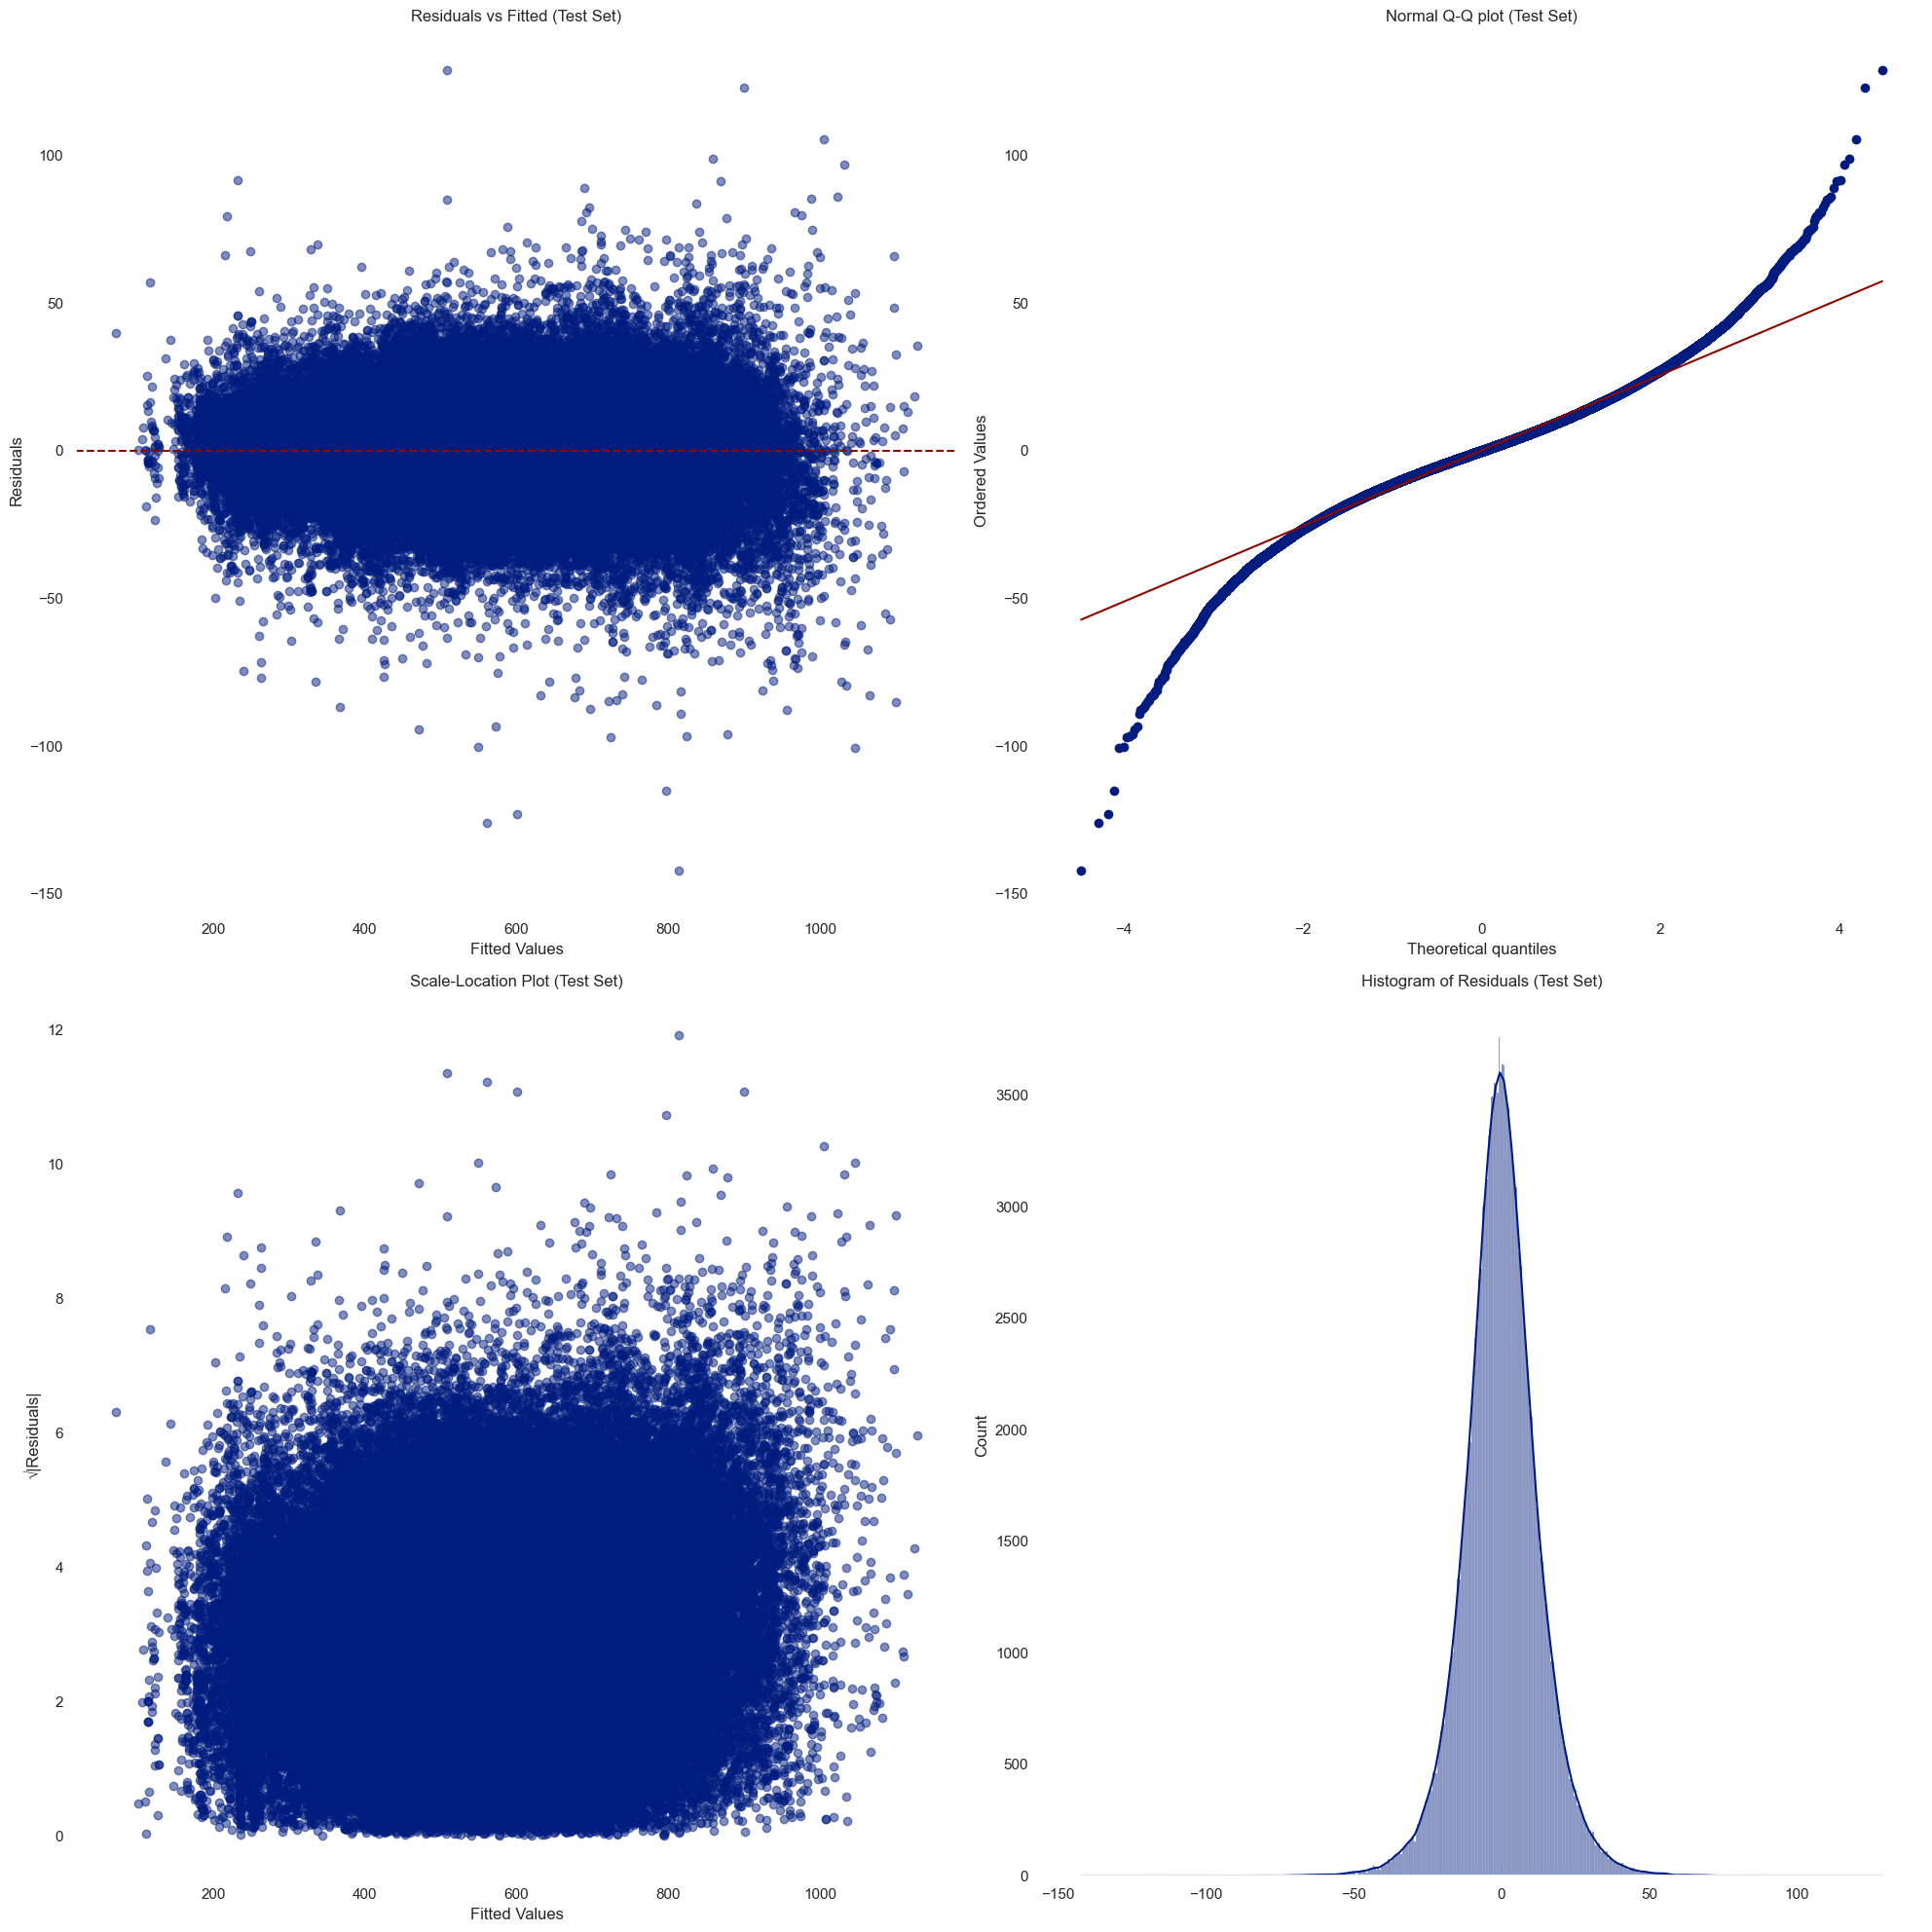

In [ ]:
residuals_test = y_test - y_preds
residuals_train = y_train - y_preds_train

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

# 1. Residuals vs Fitted Values (Test Set)
axes[0, 0].scatter(y_preds, residuals_test, alpha=0.5)
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted (Test Set)')
axes[0, 0].axhline(y=0, color='r', linestyle='--')

# 2. Q-Q Plot (Test Set)
stats.probplot(residuals_test, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title("Normal Q-Q plot (Test Set)")

# 3. Scale-Location Plot (Test Set)
axes[1, 0].scatter(y_preds, np.sqrt(np.abs(residuals_test)), alpha=0.5)
axes[1, 0].set_xlabel('Fitted Values')
axes[1, 0].set_ylabel('√|Residuals|')
axes[1, 0].set_title('Scale-Location Plot (Test Set)')

# 4. Residuals Histogram (Test Set)
sns.histplot(residuals_test, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Histogram of Residuals (Test Set)')

plt.tight_layout()
plt.show()

##


#### <span style="color:Khaki;"> Checking Random data points to evaluate the model:</span> 

In [81]:
index =4564

In [82]:
print(x_test[index])
print(y_test[index])

[ 0.39968904  0.96004684  0.50262423 -0.01465908  0.12107673  0.58385154
 -1.00732491 -0.76294031  0.96386113  0.34295461  1.02726021 -0.66245404
 -0.50197706]
647.7250120367494


In [83]:
user_data = x_test[index].reshape(1, -1)
print(user_data.ndim,user_data)
prediction = XGB_model.predict(user_data)
print(f"\n\n Predicted value (Box_Cox) = {prediction}, Actual value (Box_Cox) -{y_test[index]}, \n\n Differences is {y_test[index] - prediction} ")

2 [[ 0.39968904  0.96004684  0.50262423 -0.01465908  0.12107673  0.58385154
  -1.00732491 -0.76294031  0.96386113  0.34295461  1.02726021 -0.66245404
  -0.50197706]]


 Predicted value (Box_Cox) = [641.2645], Actual value (Box_Cox) -647.7250120367494, 

 Differences is [6.4605103] 


In [84]:
with open(r'pkls/scale_reg.pkl', 'rb') as f:
    scale_reg = pickle.load(f)

with open(r'pkls/XGB_model.pkl', 'rb') as f:
    XGB_model = pickle.load(f)

with open(r'pkls/boxcox_lambdas.pkl', 'rb') as f:
    lambda_dict = pickle.load(f)

def reverse_boxcox_transform(predicted, lambda_val):
    return inv_boxcox(predicted, lambda_val)

In [85]:
index1 = 234234

In [86]:
print(df1.iloc[index1])
print(print(df2.iloc[index1]))

month                                                    2
town                                            Ang Mo Kio
flat_type                                           3 Room
floor_area_sqm                                     67.0000
flat_model                                  New Generation
lease_commence_date                                   1976
resale_price                                   209000.0000
floors                                                   3
floor_no                                                 9
year                                                  1999
full_address               308 Ang Mo Kio Ave 1 Ang Mo Kio
price_per_sqm                                    3119.4030
remaining_lease_year                                    76
resale_price_boxcox                               488.8473
floor_area_boxcox                                   9.3850
town_en                                                  3
year_en                                                 

In [87]:
cols

['floor_area_boxcox',
 'town_en',
 'year_en',
 'flat_type_en',
 'flat_model_en',
 'lease_commence_en',
 'floor_no_en',
 'remaining_lease_year_en',
 'location_specifics',
 'floor_area_year',
 'age',
 'flat_area',
 'model_area']

In [88]:
data = df2.iloc[index1][cols].values.reshape(1,-1)
data_df = pd.DataFrame(data, columns=cols)
print(data_df)
scaled_data = scale_reg.transform(data_df)
print(scaled_data)

   floor_area_boxcox  town_en  year_en  flat_type_en  flat_model_en  \
0             9.3850   3.0000  13.0000        3.0000         1.0000   

   lease_commence_en  floor_no_en  remaining_lease_year_en  \
0            14.0000       3.0000                  10.0000   

   location_specifics  floor_area_year    age  flat_area  model_area  
0             28.1551           0.0047 3.0000   281.5510     93.8503  
[[-1.14708609 -1.4551874  -0.48349214 -1.06890262 -1.37247339 -0.81978941
  -0.01359136 -0.76294031 -1.41790736 -1.19129904  0.48635329 -0.86977645
  -0.8774306 ]]


In [89]:
prediction = XGB_model.predict(scaled_data)
print(f"Predicted value (Box_Cox) {prediction}")
transformed_predict=reverse_boxcox_transform(prediction, lambda_dict['resale_price_lambda'])
print(f"Predicted value (Inverse Box_Cox) {transformed_predict}")

Predicted value (Box_Cox) [422.6944]
Predicted value (Inverse Box_Cox) [150273.62]


In [90]:
actuals = int(df1.iloc[index1][['resale_price']].values[0])
actuals

209000

In [91]:
print(f"Predicted value (Inverse Box_Cox) {transformed_predict}, Actual value (without Box_Cox Transformation) -{actuals}, \n\n Differences is {actuals - transformed_predict}")

Predicted value (Inverse Box_Cox) [150273.62], Actual value (without Box_Cox Transformation) -209000, 

 Differences is [58726.375]
